## VERY SIMPLE RNN:

#### We create a RNN of a layer composed of five neurons.<br><br> As Activation function we use the hyperbolic tangent (tanh). <br><br>The RNN runs over only two time steps with a vector of size 3 for each time step.

In [3]:
import tensorflow as tf
import numpy as np
from datetime import datetime

#----CONSTRUCTION PHASE:----

n_inputs = 3
n_neurons = 5

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") #now = time in a specific format (YYYYMMDDHHMMSS)
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now ) # The path where we save the data: tf_logs/run-YYYYMMDDHHMMSS

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype = tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons],dtype = tf.float32))
b = tf.Variable(tf.zeros([1,n_neurons], dtype = tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b) #check why we add a bias vector with shape (1,n_neurons) -> because we had the bias vector at instance level!!!
Y1 = tf.tanh(tf.matmul(Y0,Wy) + tf.matmul(X1,Wx) +b)                                       # ->  instance + b -> (1,5) + (1,5)

init = tf.global_variables_initializer()

# Mini-batch:      instance 0, instance 1, instance 2, instance 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) #t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) #t = 1

saver = tf.train.Saver() # We will create a Saver to save our trained model parameters to disk
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # We create a filewriter that you use to write summaries to logfiles in the log directory
                                                                    # logdir = the patph of the logdir diretory. Second parameter = the graph we want to visualize


#----EXECUTION PHASE:----

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict ={X0: X0_batch, X1: X1_batch})
    save_patch = saver.save(sess, "/tmp/my_model_RNN.ckpt")
    file_writer.close()

    # For running Tensorboard, in the Anaconda Prompt IN /Progetto Forex/Python (our working directory) -> tensorboard --logdir tf_logs

#### Printing the output y(0) and y(1) :

In [14]:
print("Y0_val\n\n",Y0_val)  # with shape (n_instance, n_neurons)
print("----------------------------------------------------------------")
print("\nY1_val\n\n",Y1_val)

Y0_val

 [[ 0.28197294  0.90566266  0.8411944   0.9983283   0.866364  ]
 [-0.08455364 -0.92176336  0.39310405  1.          0.9998613 ]
 [-0.4295431  -0.999836   -0.37507161  1.          0.9999999 ]
 [-0.75202787 -1.         -1.         -0.33509326  0.50811523]]
----------------------------------------------------------------

Y1_val

 [[ 0.8978743  -1.         -0.9960234   1.          1.        ]
 [ 0.67138034 -0.9562154   0.7778875   0.9789545  -0.99204236]
 [-0.97026706 -1.         -0.854975    1.          0.9892038 ]
 [-0.9987497  -0.9999979  -0.55498934  0.9994009   0.27225658]]


## SIMPLE RNN - Static Unrolling Throught Time:-

#### Here we create an unrolled RNN network by chaining cells. <br><br> The output is the same than the previous code<br><br>If we have 50 time frames it's no a good idea setting the code like before.

In [3]:
import tensorflow as tf
import numpy as np
from datetime import datetime
#----CONTRUCTION PHASE:----

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") #now = time in a specific format (YYYYMMDDHHMMSS)
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now ) # The path where we save the data: tf_logs/run-YYYYMMDDHHMMSS

n_inputs = 3
n_neurons = 5
n_steps = 2

tf.reset_default_graph() # We need to clear our computational graph

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs]) #We take a single input placeholder. First dimension is the mini-batch size
X_seqs = tf.unstack(tf.transpose(X,perm=[1,0,2])) # X_seqs is a list of n_steps tensors of shape [None, n_inputs] with None : mini-batch size
                                                  # We need a tensor as dimension : [n_steps,None,n_inputs] ->transpose()
                                                  # With unstack function we extract a list of tensor along the first dimension (one tensor per time step)
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) # BasicRNNCell is a factory that creates copies of the cell to build the
                                                              # unrolled RNN (one for each time step)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype = tf.float32) 
# Giving the cell factory and the input tensors (this is used to create the initial state matrix, which by default is full of zero)
# The static_rnn() function calls the cell factory's __call__() function once per input, creating two copies of the cell (each
# containing a layer of five recurrent neurons), with shared weights and bias terms and it chains them just like we did earlier.
# The static_rnn() function returns two objects: the first is a Python list containing the output tensor for each time step,
# The second is a tensor containing the final states of the network. With basics cells, the final state is simply equal to the last output.
outputs  = tf.transpose(tf.stack(output_seqs), perm = [1, 0, 2])
# Here we merge all the output tensors into a single tensor using the stack() function  and swap the first two dimensions as before.

init = tf.global_variables_initializer()

# We build a single tensor that feeds the network. It contains all the mini-batch sequences:
X_batch = np.array([
          # t = 0   t = 1
         [[0,1,2], [9,8,7]], #instance 0          shape :(None,n_steps,n_inputs) -> (n_instance,n_steps,n_inputs)
         [[3,4,5], [0,0,0]], #instance 1
         [[6,7,8], [6,5,4]], #instance 2
         [[9,0,1], [3,2,1]], #instance 3      
                  ])
saver = tf.train.Saver() # We will create a Saver to save our trained model parameters to disk
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # We create a filewriter that you use to write summaries to logfiles in the log directory
                                                                    # logdir = the patph of the logdir diretory. Second parameter = the graph we want to visualize
#----EXECUTION PHASE:----

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X : X_batch})
    save_patch = saver.save(sess, "/tmp/my_model_RNN2.ckpt")
    file_writer.close()
    
# For running Tensorboard, in the Anaconda Prompt IN /Progetto Forex/Python (our working directory) -> tensorboard --logdir tf_logs


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


#### Printing some data: (shape/type/class attributes & other stuff...)

In [23]:
print(tf.shape(X_seqs))
print("----------------")
print(X_seqs)
print("----------------")
print(type(X_seqs))
dir(tf.Tensor)

Tensor("Shape_15:0", shape=(3,), dtype=int32)
----------------
[<tf.Tensor 'unstack:0' shape=(?, 3) dtype=float32>, <tf.Tensor 'unstack:1' shape=(?, 3) dtype=float32>]
----------------
<class 'list'>


['OVERLOADABLE_OPERATORS',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_as_node_def_input',
 '_as_tf_output',
 '_c_api_shape',
 '_get_input_ops_without_shapes',
 '_override_operator',
 '_rank',
 '_shape',
 '_shape_as_list',
 '_shape_tuple'

In [24]:
# Check the working directory: 

import os
cwd = os.getcwd()
print(cwd)

C:\Users\nabu-pc\Desktop\Progetto Forex\Python\Basic Concept Deep Learning


In [2]:
#We get a single outputs_val tensor for all instances, all time steps and all neurons:
print(outputs_val)

[[[ 0.54068077  0.77113384 -0.18281321 -0.1737778   0.90367615]
  [ 0.9999933   0.99814194  0.9124846  -0.98103976  0.9969487 ]]

 [[ 0.9967356   0.9881427   0.29780102 -0.7337092   0.9925271 ]
  [-0.8338657   0.17228061 -0.27827862  0.02379978  0.90409595]]

 [[ 0.9999822   0.99944955  0.66353416 -0.9351422   0.999444  ]
  [ 0.99739057  0.9799872   0.63207984 -0.78449744  0.9918195 ]]

 [[ 0.98553395  0.5199953   0.84435177  0.8455966  -0.9997829 ]
  [ 0.953145    0.9689828   0.8994938  -0.948009    0.22778754]]]


In [5]:
print(type(basic_cell))

<class 'tensorflow.python.ops.rnn_cell_impl.BasicRNNCell'>


## TRAINING A SEQUENCE CLASSIFIER:

#### We train an RNN to classify  MNSIST images. <br><br> A convolutional neural network would be better for image classification but here we have a simple example (each MNSIST image has 28 X 28 pixels) <br><br> We use a single cell with inside 150 recurrent neurons + a full connected layer containing 10 neurons (one per class) followed by a softmax layer. (Multinomial Logistic Regression or Softmax Regression)


### Importing the dataset MNIST and save it on a specific path:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data #We load the MNIST data and reshape the test data as [batch_size, n_steps, n_inputs]
   # as the network expectes

mnist = input_data.read_data_sets("/tmp/data/")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Shape & attribute of different object involves :

In [3]:
print(type(input_data))
print("-----------------------")
print(type(mnist.test.images))
print("-----------------------")
print(mnist.test.images.shape, "We have a shape [# images;[# inputs * # steps]]")

#*********MODULE CLASS:***************************************************************************************************

# ---------Module vs Class type:------------

# Classes are blueprints (progetti )that allow you to create instance with attributes and bound functionality
# Classes support inheritahnce, metaclasses and descriptors

#                VS

# Modules can't do any of this. Module are essentially singleton instance (???) of an internal module class and all their globals
# (globals variables???) are attibutes on the module instance. You can manipulate those attributes as needed (add, remove and update)
# but take into account (prendere in considerazione) these still form (dare forma) the global namespace for all code defined in that
# module.

#----------Module description:--------------

# *Module is a builtin class just like list, tuple and dict

# *When you import a module (single Python file) or a package (folder with __init__.py)
#  1- A new instance of module class will be created
#  2- The classes/method/variables you defined in that imported Python file will be added as the attributes of this module instance
#     (if it is a package, it will be the classes/methods/variables defined in __init__.py that are added)

#**************************************************************************************************************************

<class 'module'>
-----------------------
<class 'numpy.ndarray'>
-----------------------
(10000, 784) We have a shape [# images;[# inputs * # steps]]


In [29]:
dir(tf.Tensor)

['OVERLOADABLE_OPERATORS',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_as_node_def_input',
 '_as_tf_output',
 '_c_api_shape',
 '_get_input_ops_without_shapes',
 '_override_operator',
 '_rank',
 '_shape',
 '_shape_as_list',
 '_shape_tuple'

### Reshape the Test Set:

In [4]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))  #     The original shape [# images;[# inputs * # steps]]
y_test = mnist.test.labels
print("------------------------------------------------")
print(X_test[len(X_test)-200])   # 9800th matrix of X_test [10000,27,27]
print("------------------------------------------------")
print("X  shape:", X_test.shape)
print("------------------------------------------------")
print("y shape:", y_test.shape)
print("------------------------------------------------")
print("Type mnist.test :",type(mnist.test))

------------------------------------------------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.    

### Running the Algo:

In [6]:
import tensorflow as tf
import numpy as np
from datetime import datetime

#----CONSTRUCTION PHASE:----

now = datetime.utcnow().strftime("%Y%m%d%H%M%S") #now = time in a specific format (YYYYMMDDHHMMSS)
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now ) # The path where we save the data: tf_logs/run-YYYYMMDDHHMMSS



n_steps = 28
n_inputs= 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

tf.reset_default_graph() # We need to clear our computational graph

X = tf.placeholder(tf.float32,[None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])   #It a placeholder for the target class

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype= tf.float32)  #dynamic run uses a while_loop() cycle to run over the cell the
# the appropriate number of times. It accepts a single tensor for all inputs at every time step (shape: [None, n_steps, n_neurons])
#We don't need to stack/unstack or transpose like Static Unrolling. Where Outputs -> vectors of output of last cell, state-> last matrix
#of weight of last cell (Wy) ???note sure about state shape--> it's a kernel [neuron+inputs,neurons] or [inputs, neurons] ???
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels= y, logits=logits) #How well a set of estimated class match the target classes
                                                                                    #Calculate softmax+ loss function
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y ,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()


#----EXECUTION PHASE:----

n_epochs = 5
batch_size = 150


saver = tf.train.Saver() # We will create a Saver to save our trained model parameters to disk
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # We create a filewriter that you use to write summaries to logfiles in the log directory
                                                                    # logdir = the patph of the logdir diretory. Second parameter = the graph we want to visualize

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1,n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_patch = saver.save(sess, "/tf_logs/my_model_RNN3.ckpt")
    file_writer.close()

# For running Tensorboard, in the Anaconda Prompt IN /Progetto Forex/Python (our working directory) -> tensorboard --logdir tf_logs


0 Train accuracy: 0.93333334 Test accuracy: 0.9228
1 Train accuracy: 0.94666666 Test accuracy: 0.9443
2 Train accuracy: 0.94 Test accuracy: 0.9536
3 Train accuracy: 0.97333336 Test accuracy: 0.9563
4 Train accuracy: 0.98 Test accuracy: 0.956


### Verify the shape of States/Outputs (and oher stuff!!!):

In [24]:
print(states.shape)
print("------------")
print(outputs.shape)
print("------------")
print(np.frombuffer(b'\\001\\000\\000\\000\\000\\000\\000\\000'))

(?, 150)
------------
(?, 28, 150)
------------
[1.39810127e-76 1.39810127e-76 1.39810127e-76 1.39810127e-76]


## Training to Predict Time Series:

#### We create a RNN with 100 recurrent neurons and it enrolls over 20 time steps since each training instance will be 20 inputs long<br><br>Each input will contain only one feature (the value at time). <br><br>  Also the targets are also sequences of 20 inputs, each contains a single value. 

### Creating a Time Series:

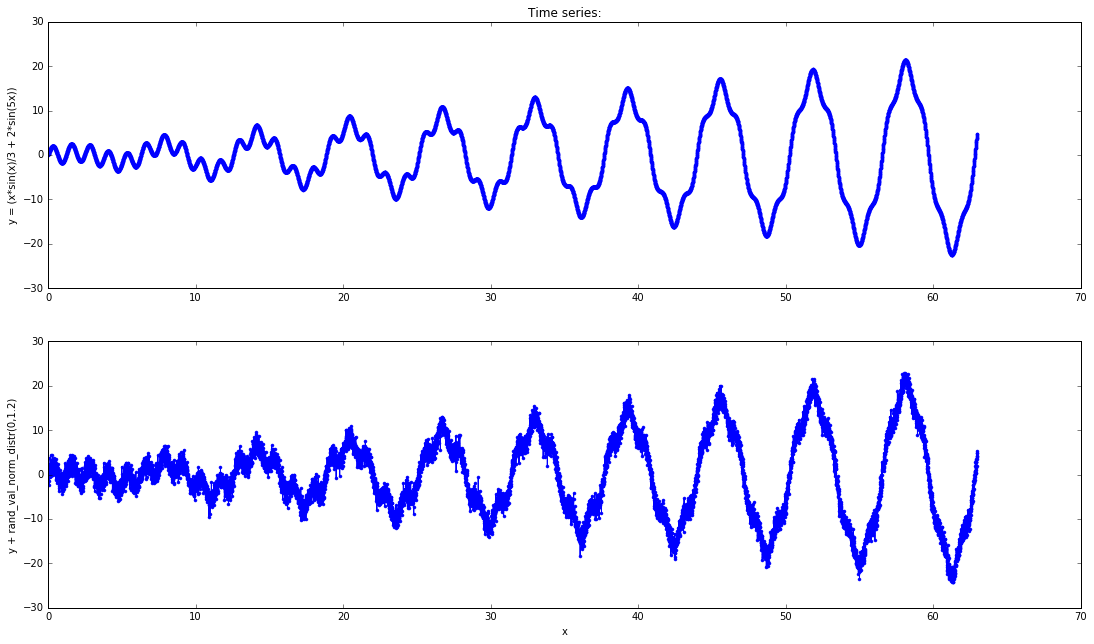

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import* 

#We create two time series: 1) first according to a y = (x*sin(x)/3 + 2*sin(5x)) 2) y + random_value_from_normal_distr(media,var) 

#1) First time series: y = (x*sin(x)/3 + 2*sin(5x))
x = np.arange(0.0, 63, 0.0063)    #10000 point with step 0,0063

y = np.zeros(len(x))

for i in range(len(x)):
    y[i] = x[i]*sin(x[i])/3 +2*sin(5*x[i])



#2) Second time series: y + rand_distr_norm(avg,var), with avg = 0 , var = 0,1   

# Ps: Range of random value (according to normal distribution probability) is avg +/- 3 var

s = np.random.normal(0,1.2,10000)  #random value from a normal distribution (avg = 0, var = 1.2)

y2 = np.zeros(len(x))

for i in range(len(s)):
    y2[i] =  s[i] + y[i]
    
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


#Printing two functions togheter

plt.subplot(2,1,1)
plt.plot(x,y,'.-')
plt.title("Time series:")
plt.ylabel('y = (x*sin(x)/3 + 2*sin(5x))')


plt.subplot(2,1,2)
plt.plot(x,y2,'.-')
plt.xlabel('x')
plt.ylabel('y + rand_val_norm_distr(0,1.2)')

    
plt.show()

### We reshape the Time Series according to shape requests by the Algo:

In [11]:
y2_reshape = np.reshape(y2,(-1,20,1))
print(y2_reshape)

[[[  1.27122986]
  [  2.31680603]
  [  1.32310705]
  [  2.81083683]
  [  3.37367602]
  [  0.13172312]
  [  0.75346458]
  [  0.96139973]
  [  2.05319527]
  [  0.09947347]
  [  0.20770302]
  [ -2.16638489]
  [ -1.33263836]
  [ -2.89839968]
  [ -0.73921315]
  [ -0.2760576 ]
  [ -3.12504131]
  [ -0.51200941]
  [ -0.58264068]
  [  0.59633621]]

 [[  2.16922643]
  [  3.42747299]
  [  3.04947538]
  [  1.9996841 ]
  [  1.26302523]
  [  2.12486718]
  [  0.27575155]
  [ -0.80681324]
  [  1.90463749]
  [ -1.8444132 ]
  [ -0.88382258]
  [ -3.16184711]
  [  0.80905325]
  [ -2.05275481]
  [ -0.35013375]
  [ -1.66479213]
  [ -0.77071143]
  [  2.86326983]
  [ -0.63189346]
  [  2.02276895]]

 [[  2.90890454]
  [  3.17617116]
  [  1.1322091 ]
  [  3.05688894]
  [  2.01635005]
  [  0.72200789]
  [  0.30856677]
  [ -1.71941921]
  [ -0.73858784]
  [ -1.75306078]
  [ -2.61748581]
  [ -1.63967704]
  [ -1.9748207 ]
  [ -0.25873793]
  [ -0.6222512 ]
  [ -0.04510306]
  [  0.18278479]
  [  0.88185936]
  [  0.141

### Some test (X_bath and y_bath):

In [56]:
y_batch = np.zeros((1,20,1),dtype=np.float32)
X_batch = np.zeros((1,20,1),dtype= np.float32)

X_batch = y2_reshape[3] 

for i in range(20):
    if i == 19: break
    y_batch[0][i] = y2_reshape[0][i+1]
y_batch[0][-1] = y2_reshape[1][0]
    

print("X_batch\n\n",X_batch,"y_batch\n\n",y_batch, "shape:", y_batch.shape)

X_batch

 [[-0.59643517]
 [-0.83491037]
 [-1.20208906]
 [-1.21480934]
 [-2.91979668]
 [-1.18796011]
 [-2.8719523 ]
 [-3.33687869]
 [-3.91137129]
 [-2.02734264]
 [-3.30692694]
 [-3.34247247]
 [-1.31573846]
 [ 2.78025059]
 [-0.03283063]
 [-2.79793389]
 [ 1.83511174]
 [ 1.27353139]
 [-0.66221948]
 [ 0.06246969]] y_batch

 [[[ 2.316806  ]
  [ 1.323107  ]
  [ 2.8108368 ]
  [ 3.373676  ]
  [ 0.13172312]
  [ 0.7534646 ]
  [ 0.96139973]
  [ 2.0531952 ]
  [ 0.09947347]
  [ 0.20770302]
  [-2.166385  ]
  [-1.3326384 ]
  [-2.8983996 ]
  [-0.73921317]
  [-0.2760576 ]
  [-3.1250412 ]
  [-0.51200944]
  [-0.5826407 ]
  [ 0.5963362 ]
  [ 2.1692264 ]]] shape: (1, 20, 1)


### Developting the Algorithm:

In [64]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

#----CONSTRUCTION PHASE:----

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation= tf.nn.relu), output_size= n_outputs)
outputs ,states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

learning_rate = 0.001

tf.reset_default_graph() # We need to clear our computational graph

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

#----EXECUTION PHASE:----

n_iterations = 1500
batch_size = 5

y_batch = np.zeros((5,20,1),dtype= np.float32)
X_batch = np.zeros((5,20,1),dtype= np.float32)

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        m = 0
        for k in range(len(y2_reshape)//batch_size):
            X_batch = y2_reshape[m : m + batch_size]
            for l in range(batch_size):
                for i in range(20):
                    if i == 19: break
                    y_batch[l][i] = y2_reshape[l+m][i+1]
                    y_batch[l][-1] = y2_reshape[l+m+1][0]
            sess.run(training_op, feed_dict ={X:X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\MSE:", mse)
            m = m + 5

ValueError: Tensor("Square:0", shape=(?, 20, 1), dtype=float32) must be from the same graph as Tensor("Const:0", shape=(3,), dtype=int32).

In [59]:
print(len(y2_reshape))

45
